# Levenshtein distance and spelling corrections

In [ ]:
import collections
import elasticsearch
import elasticsearch_dsl
import itertools
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import os
# import spacy
# import morfeusz2
from spacy.lang.pl import Polish

3. Use SpaCy tokenizer API to tokenize the text from the cleaned law corpus.


In [1]:
nlp = Polish()
tokenizer = nlp.tokenizer

In [7]:
text_tokenized = {}

for root, _, files in os.walk('./ustawy'):
    for file_name in files:
        path = os.path.join(root, file_name)
        with open(path, encoding='utf-8') as file:
            content = file.read()
            text_tokenized[file_name] = [token.text.lower() for token in tokenizer(content)]

In [8]:
text_tokenized['2004_2701.txt']

['\n\n\n\n',
 'dz',
 '.',
 'u',
 '.',
 'z',
 '2004',
 'r',
 '.',
 'nr',
 '273',
 ',',
 'poz',
 '.',
 '2701',
 '\n    \n                                        \n                                   ',
 'u',
 's',
 't',
 'a',
 'w',
 'a',
 '\n                         ',
 'z',
 'dnia',
 '22',
 'października',
 '2004',
 'r',
 '.',
 '\n                                        \n               ',
 'o',
 'zmianie',
 'ustawy',
 'o',
 'finansowym',
 'wspieraniu',
 'inwestycji',
 '\n                                        \n                                     ',
 'art',
 '.',
 '1',
 '.',
 '\n',
 'w',
 'ustawie',
 'z',
 'dnia',
 '20',
 'marca',
 '2002',
 'r',
 '.',
 'o',
 'finansowym',
 'wspieraniu',
 'inwestycji',
 '(',
 'dz',
 '.',
 'u',
 '.',
 '\n',
 'nr',
 '41',
 ',',
 'poz',
 '.',
 '363',
 'i',
 'nr',
 '141',
 ',',
 'poz',
 '.',
 '1177',
 ',',
 'z',
 '2003',
 'r',
 '.',
 'nr',
 '159',
 ',',
 'poz',
 '.',
 '1537',
 'oraz',
 'z',
 '2004',
 'r',
 '.',
 '\n',
 'nr',
 '123',
 ',',
 'poz',
 '.',
 '1

4. Compute frequency list for each of the processed files.

In [9]:
tokenized_frequencies = {
    path: collections.Counter(tokens)
    for (path, tokens)
    in text_tokenized.items()
}

In [10]:
for file, counter in sorted(tokenized_frequencies.items()):
    print(f'{file.split("/")[-1]}: {counter.most_common(5)}')

1993_599.txt: [('|', 1634), ('-', 858), ('\n', 561), ('.', 497), ('   ', 485)]
1993_602.txt: [('.', 155), (',', 89), ('w', 63), ('"', 44), ('\n          ', 36)]
1993_645.txt: [('.', 23), (',', 7), ('\n', 7), ('z', 6), ('r', 6)]
1993_646.txt: [('.', 688), (',', 610), ('w', 506), ('-', 324), ('"', 304)]
1994_150.txt: [('.', 20), (',', 6), ('w', 6), ('z', 5), ('i', 4)]
1994_195.txt: [('.', 2724), (',', 2197), ('\n  ', 1368), ('w', 1226), ('\n', 1117)]
1994_201.txt: [('.', 36), (',', 19), ('\n                ', 19), ('i', 9), ('z', 8)]
1994_214.txt: [('.', 17), ('\n', 5), ('w', 4), ('"', 4), ('z', 3)]
1994_215.txt: [('.', 39), (',', 23), ('w', 14), ('z', 8), ('\n       ', 8)]
1994_288.txt: [(',', 26), ('.', 23), ('w', 17), (')', 16), ('\n', 11)]
1994_294.txt: [(',', 63), ('.', 53), ('nr', 33), ('poz', 33), ('\n ', 14)]
1994_331.txt: [('.', 26), (',', 10), ('z', 5), ('r', 5), ('w', 5)]
1994_332.txt: [('.', 48), (',', 31), ('nr', 18), ('poz', 18), ('w', 15)]
1994_344.txt: [('.', 693), (',', 

5. Aggregate the result to obtain one global frequency list.

In [11]:
all_tokens = [token for tokens in text_tokenized.values() for token in tokens]
collections.Counter(all_tokens).most_common(50)

[('.', 437694),
 (',', 341126),
 ('w', 201224),
 ('\n', 181703),
 (')', 100194),
 ('i', 90009),
 ('art', 83804),
 ('z', 82443),
 ('1', 73108),
 ('o', 64776),
 ('-', 61714),
 ('do', 60735),
 ('2', 57027),
 ('"', 54913),
 ('\n  ', 54885),
 ('\n     ', 54047),
 ('ust', 53636),
 ('na', 50647),
 ('\n   ', 46777),
 ('się', 45886),
 ('lub', 45800),
 ('poz', 45224),
 ('nr', 44950),
 (':', 39203),
 ('3', 39084),
 ('oraz', 33558),
 ('r', 33177),
 ('\n           ', 32942),
 ('mowa', 28783),
 (';', 25266),
 ('4', 24271),
 ('nie', 22990),
 ('przez', 20953),
 ('\n       ', 20937),
 ('\n             ', 20532),
 ('§', 20474),
 ('pkt', 19124),
 ('dnia', 17954),
 ('których', 17932),
 ('5', 17435),
 ('\n ', 17290),
 ('a', 17133),
 ('_', 16809),
 ('od', 16687),
 ('\n         ', 16498),
 ('po', 13547),
 (' ', 13542),
 ('jest', 13197),
 ('ustawy', 13099),
 ('(', 13031)]

6. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).

In [12]:
tokenizer('ęśąćż')[0].is_alpha

True

In [13]:
tokenizer('Ąśćź')[0].is_stop

False

In [14]:
tokenizer('oraz')[0].is_stop

True

In [15]:
tokenizer('oraz')[0].is_alpha

True

In [16]:
tokens_cleaned = {}

for root, _, files in os.walk('./ustawy'):
    for file_name in files:
        path = os.path.join(root, file_name)
        with open(path, encoding='utf-8') as file:
            content = file.read()
            tokens_cleaned[path] = [
                token.text.lower()
                for token
                in tokenizer(content)
                if token.is_alpha
                and len(token) > 1
            ]

Most popular tokens for each file - top 5 worlds after elimination of shor words and non-letter characters

In [17]:
tokenized_cleaned_frequencies = {
    path: collections.Counter(tokens)
    for (path, tokens)
    in tokens_cleaned.items()
}

In [18]:
for file, counter in sorted(tokenized_cleaned_frequencies.items()):
    print(f'{file.split("/")[-1]}: {counter.most_common(5)}')

1993_599.txt: [('ust', 118), ('art', 75), ('do', 69), ('się', 66), ('towarów', 49)]
1993_602.txt: [('ust', 29), ('nr', 28), ('poz', 28), ('art', 25), ('wynagrodzenia', 13)]
1993_645.txt: [('nr', 6), ('poz', 6), ('dnia', 3), ('oraz', 3), ('art', 3)]
1993_646.txt: [('ust', 193), ('art', 166), ('się', 126), ('pkt', 107), ('od', 102)]
1994_150.txt: [('art', 4), ('lub', 4), ('dnia', 3), ('do', 3), ('dz', 2)]
1994_195.txt: [('art', 510), ('do', 502), ('na', 459), ('się', 349), ('lub', 321)]
1994_201.txt: [('art', 7), ('oraz', 5), ('rejonów', 5), ('nr', 4), ('poz', 4)]
1994_214.txt: [('dnia', 3), ('art', 3), ('dz', 2), ('nr', 2), ('poz', 2)]
1994_215.txt: [('ust', 7), ('nr', 6), ('poz', 6), ('art', 6), ('dnia', 3)]
1994_288.txt: [('rolnych', 7), ('art', 7), ('dnia', 4), ('zadania', 4), ('związanych', 3)]
1994_294.txt: [('nr', 33), ('poz', 33), ('dnia', 4), ('od', 4), ('art', 3)]
1994_331.txt: [('nr', 4), ('poz', 4), ('do', 4), ('dnia', 3), ('art', 3)]
1994_332.txt: [('nr', 18), ('poz', 18), (

Top 50 most popular tokens aggregated from all files

In [19]:
all_tokens = [token for tokens in tokens_cleaned.values() for token in tokens]
global_frequency = collections.Counter(all_tokens)
global_frequency.most_common(50)

[('art', 83804),
 ('do', 60735),
 ('ust', 53636),
 ('na', 50647),
 ('się', 45886),
 ('lub', 45800),
 ('poz', 45224),
 ('nr', 44950),
 ('oraz', 33558),
 ('mowa', 28783),
 ('nie', 22990),
 ('przez', 20953),
 ('pkt', 19124),
 ('dnia', 17954),
 ('których', 17932),
 ('od', 16687),
 ('po', 13547),
 ('jest', 13197),
 ('ustawy', 13099),
 ('może', 12096),
 ('jeżeli', 12044),
 ('którym', 11789),
 ('za', 11146),
 ('brzmienie', 10576),
 ('spraw', 10021),
 ('otrzymuje', 9835),
 ('dz', 8885),
 ('albo', 8708),
 ('dodaje', 8423),
 ('ich', 8199),
 ('dla', 7934),
 ('pracy', 7631),
 ('minister', 7580),
 ('której', 7476),
 ('brzmieniu', 7295),
 ('drodze', 7179),
 ('podstawie', 6849),
 ('stosuje', 6680),
 ('przypadku', 6494),
 ('niż', 6452),
 ('tym', 6366),
 ('jego', 6320),
 ('są', 6156),
 ('być', 6120),
 ('zakresie', 6098),
 ('właściwy', 6094),
 ('państwa', 5839),
 ('przepisy', 5839),
 ('wyrazy', 5817),
 ('ze', 5509)]

7. Make a plot in a logarithmic scale (for X and Y):
  - X-axis should contain the rank of a term, meaning the first rank belongs to the term with the highest number of occurrences; the terms with the same number of occurrences should be ordered by their name,
  - Y-axis should contain the number of occurrences of the term with given rank.

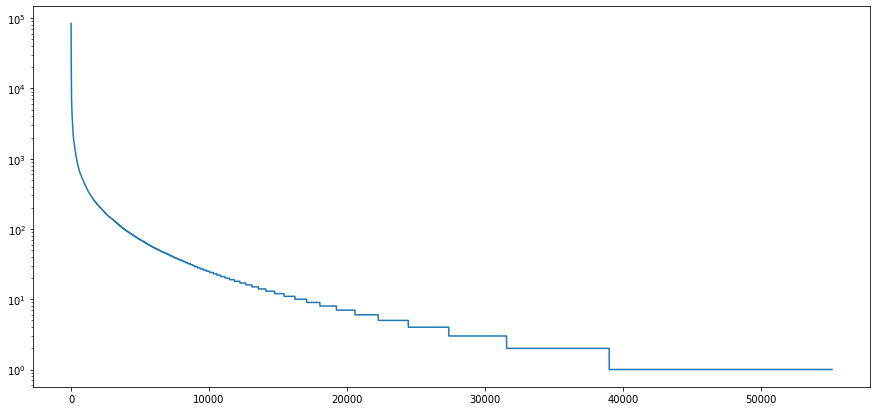

In [20]:
sorted_global_frequency = sorted(global_frequency.items(), key=lambda item: (-item[1], item[0]))

plt.figure(figsize=(15, 7))
plt.plot(range(1, len(sorted_global_frequency) + 1), [frequency for (_, frequency) in sorted_global_frequency])
plt.yscale('log')

8. Install Morfeusz (Binding dla Pythona) and use it to find all words that do not appear in that dictionary.

In [22]:
morfeusz = morfeusz2.Morfeusz()

In [30]:
words_not_in_morf_counter = list(filter(lambda w: morfeusz.analyse(w[0])[0][2][2] == "ign", global_frequency.items()))
words_in_morf_counter = list(filter(lambda w: morfeusz.analyse(w[0])[0][2][2] != "ign", global_frequency.items()))
words_not_in_morf_counter

[('poz', 45224),
 ('morpak', 3),
 ('polonit', 4),
 ('azbestowo', 11),
 ('produkcyjno', 4),
 ('cobrpib', 3),
 ('hydroizolacyjnych', 1),
 ('techniczno', 125),
 ('pojedyńczej', 1),
 ('medyczno', 1),
 ('operacyjno', 209),
 ('socjalno', 8),
 ('obsługowo', 1),
 ('mieszkalno', 5),
 ('późn', 1065),
 ('dyplomatyczno', 41),
 ('kv', 10),
 ('kazeiniany', 1),
 ('realokacji', 10),
 ('kazeinianów', 4),
 ('ekonomiczno', 22),
 ('future', 1),
 ('ukoń', 1),
 ('ăúĺîéá', 1),
 ('ëóúôáłcenia', 1),
 ('przyz', 1),
 ('nanie', 1),
 ('kowskiego', 1),
 ('rzone', 1),
 ('nieoprocentowych', 1),
 ('str', 516),
 ('geoportal', 1),
 ('ortofotomapy', 4),
 ('termilnie', 1),
 ('georeferencyjnych', 1),
 ('zm', 192),
 ('ortoobrazy', 1),
 ('społeczno', 137),
 ('pomiarowo', 20),
 ('georeferencyjnej', 1),
 ('np', 85),
 ('meteorologiczno', 1),
 ('oceanograficzno', 1),
 ('inspire', 1),
 ('organizacyjno', 58),
 ('know', 11),
 ('how', 11),
 ('sww', 216),
 ('kontrolno', 30),
 ('emerytalno', 42),
 ('cpc', 2),
 ('stępstwo', 1),
 ('niew

9. Find 30 words with the highest ranks that do not belong to the dictionary.

In [31]:
words_not_in_morf = list(filter(lambda x: x[0], words_not_in_morf_counter[:30]))
words_not_in_morf_counter[:30]

[('poz', 45224),
 ('morpak', 3),
 ('polonit', 4),
 ('azbestowo', 11),
 ('produkcyjno', 4),
 ('cobrpib', 3),
 ('hydroizolacyjnych', 1),
 ('techniczno', 125),
 ('pojedyńczej', 1),
 ('medyczno', 1),
 ('operacyjno', 209),
 ('socjalno', 8),
 ('obsługowo', 1),
 ('mieszkalno', 5),
 ('późn', 1065),
 ('dyplomatyczno', 41),
 ('kv', 10),
 ('kazeiniany', 1),
 ('realokacji', 10),
 ('kazeinianów', 4),
 ('ekonomiczno', 22),
 ('future', 1),
 ('ukoń', 1),
 ('ăúĺîéá', 1),
 ('ëóúôáłcenia', 1),
 ('przyz', 1),
 ('nanie', 1),
 ('kowskiego', 1),
 ('rzone', 1),
 ('nieoprocentowych', 1)]

10. Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [32]:
import random

random.shuffle(words_not_in_morf_counter)

random_words_5 = []

for word, count in words_not_in_morf_counter:
    if count == 5:
        random_words_5.append(word)
    if len(random_words_5) == 30:
        break
        
random_words_5

['schetyna',
 'urt',
 'vista',
 'edukacyjno',
 'tzn',
 'mieszkalno',
 'regazyfikacyjnego',
 'swine',
 'najmnie',
 'kpwig',
 'tów',
 'ośc',
 'funkcjonalno',
 'inci',
 'shigella',
 'chelatującym',
 'rr',
 'heptanol',
 'jwh',
 'ym',
 'zawart',
 'próbobiorców',
 'denitracyjne',
 'ami',
 'agave',
 'rialnego',
 'wapnio',
 'wodno',
 'winopochodne',
 'nym']

11. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from lists defined in points 9 and 10. (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)

In [36]:
import time
start = time.time()
for word in list(map(lambda x: x[0], words_not_in_morf)):
    i = 0
    found = False
    while(not found):
        i += 1
        for dict_word, _ in words_in_morf_counter:
            if Levenshtein.distance(word, dict_word) == i:
                print("'"+word+"'", ": Did you mean", "'"+dict_word+"'?")
                found = True
                break  

print(f'TIME: {time.time() - start} s')

'poz' : Did you mean 'po'?
'morpak' : Did you mean 'morza'?
'polonit' : Did you mean 'polonia'?
'azbestowo' : Did you mean 'azbest'?
'produkcyjno' : Did you mean 'produkcyjne'?
'cobrpib' : Did you mean 'cierpi'?
'hydroizolacyjnych' : Did you mean 'termoizolacyjnych'?
'techniczno' : Did you mean 'techniczne'?
'pojedyńczej' : Did you mean 'pojedynczej'?
'medyczno' : Did you mean 'medyczne'?
'operacyjno' : Did you mean 'operacyjne'?
'socjalno' : Did you mean 'socjalne'?
'obsługowo' : Did you mean 'usługowe'?
'mieszkalno' : Did you mean 'mieszkalny'?
'późn' : Did you mean 'plan'?
'dyplomatyczno' : Did you mean 'dyplomatyczny'?
'kv' : Did you mean 'iv'?
'kazeiniany' : Did you mean 'kazeiny'?
'realokacji' : Did you mean 'realizacji'?
'kazeinianów' : Did you mean 'kapelanów'?
'ekonomiczno' : Did you mean 'ekonomiczne'?
'future' : Did you mean 'futer'?
'ukoń' : Did you mean 'koń'?
'ăúĺîéá' : Did you mean 'dz'?
'ëóúôáłcenia' : Did you mean 'kształcenia'?
'przyz' : Did you mean 'przez'?
'nanie' 

In [37]:
import time
start = time.time()
for word in random_words_5:
    i = 0
    found = False
    while(not found):
        i += 1
        for dict_word, _ in words_in_morf_counter:
            if Levenshtein.distance(word, dict_word) == i:
                print(f"'{word}' : Did you mean '{dict_word}'?")
                found = True
                break  

print(f'TIME: {time.time() - start} s')

'schetyna' : Did you mean 'schedy'?
'urt' : Did you mean 'art'?
'vista' : Did you mean 'lista'?
'edukacyjno' : Did you mean 'edukacyjną'?
'tzn' : Did you mean 'ten'?
'mieszkalno' : Did you mean 'mieszkalny'?
'regazyfikacyjnego' : Did you mean 'ratyfikacyjnego'?
'swine' : Did you mean 'win'?
'najmnie' : Did you mean 'najmniej'?
'kpwig' : Did you mean 'krwi'?
'tów' : Did you mean 'łów'?
'ośc' : Did you mean 'ości'?
'funkcjonalno' : Did you mean 'funkcjonalne'?
'inci' : Did you mean 'inni'?
'shigella' : Did you mean 'skreśla'?
'chelatującym' : Did you mean 'chorującym'?
'rr' : Did you mean 'nr'?
'heptanol' : Did you mean 'metanol'?
'jwh' : Did you mean 'kwh'?
'ym' : Did you mean 'tym'?
'zawart' : Did you mean 'zawarte'?
'próbobiorców' : Did you mean 'pracobiorcą'?
'denitracyjne' : Did you mean 'dekoracyjne'?
'ami' : Did you mean 'ani'?
'agave' : Did you mean 'agape'?
'rialnego' : Did you mean 'realnego'?
'wapnio' : Did you mean 'wapnia'?
'wodno' : Did you mean 'wolno'?
'winopochodne' : Di

12. Load SGJP dictionary (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) and use fuzzy matching to obtain the possible corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [10]:
from elasticsearch import Elasticsearch
es = Elasticsearch(['http://localhost:9200/'])
es.info()

{'name': 'KRKML0004.local',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': '4RgVB8ahROeKb-55kRVLEQ',
 'version': {'number': '8.4.3',
  'build_flavor': 'default',
  'build_type': 'tar',
  'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73',
  'build_date': '2022-10-04T07:17:24.662462378Z',
  'build_snapshot': False,
  'lucene_version': '9.3.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

In [11]:
from elasticsearch import helpers

def insert_sgjp_to_es(filename):
    with open(filename, encoding='utf-8') as f:
        for line in f:
            if len(line.split()) != 4:
                continue
            else:
                yield {
                    "_index": "sgjp",
                    "word": line.split()[0],
                }
                break
        for line in f:
            yield {
                "_index": "sgjp",
                "word": line.split()[0],
            }

helpers.bulk(es, insert_sgjp_to_es("sgjp-20221106.tab"), chunk_size=100000, request_timeout=6000)

(7412267, [])

In [18]:
took = 0
for word in random_words_5:
    global took
    for i in [1, 2]:
        response = es.search(
                    index="sgjp", 
                    body={
                        "query": {
                            "fuzzy": {
                                "word": {
                                    "value": word,
                                    "fuzziness": i
                                }
                            }
                        }
                    })
        if len(response['hits']['hits']) > 0:
            print(f"{word} : Did you mean {response['hits']['hits'][0]['_source']['word']}?")
        else:
            print("Nothing found for {word}")
        took += response['took']    

print(f"TIME {took} ms")

/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_69459/3023051781.py:5: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.search(


Nothing found for {word}
schetyna : Did you mean chatyna?
urt : Did you mean Kurt?
urt : Did you mean Kurt?
vista : Did you mean lista?
vista : Did you mean lista?
edukacyjno : Did you mean edukacyjno?
edukacyjno : Did you mean edukacyjno?
tzn : Did you mean tzn?
tzn : Did you mean tzn?
mieszkalno : Did you mean mieszkalno?
mieszkalno : Did you mean mieszkalno?
Nothing found for {word}
regazyfikacyjnego : Did you mean denazyfikacyjnego?
swine : Did you mean swing?
swine : Did you mean swing?
najmnie : Did you mean Najmanie?
najmnie : Did you mean Najmanie?
Nothing found for {word}
kpwig : Did you mean Kowin?
tów : Did you mean Lów?
tów : Did you mean Lów?
ośc : Did you mean Owc?
ośc : Did you mean Owc?
funkcjonalno : Did you mean funkcjonalno?
funkcjonalno : Did you mean funkcjonalno?
inci : Did you mean Ingi?
inci : Did you mean Ingi?
Nothing found for {word}
Nothing found for {word}
Nothing found for {word}
chelatującym : Did you mean nielatującym?
rr : Did you mean ro-ro?
rr : Did y

13. Compare the results of your algorithm and output of ES.

Elasticsearch allows us to pass fuzzines = 0, 1 or 2, in our algorithm we may have more flexibility, but elasticsearch works much faster. As we can see es found a lot of words that match, but often they doesn't make sense for Polish articles, in my algorithm results are more promissing, but with our algorith me can specify exacly the distance we want, here we try to find best solution

In [21]:
for word, _ in words_not_in_morf_counter.extend(words_in_morf_counter):
    response = es.search(
                index="sgjp", 
                body={
                    "query": {
                        "fuzzy": {
                            "word": {
                                "value": word,
                                "fuzziness": 2
                            }
                        }
                    }
                })
    if len(response['hits']['hits']) == 0:
        count += 1.0
        
print(f"True misspelings {count / len(words_not_in_morf_counter.extend(words_in_morf_counter)) * 100}%")

True misspelings 3.27%


### 14. Draw conclusions regarding:
  - the distribution of words in the corpus,
  - the number of true misspellings vs. the number of unknown words,
  - the performance of your method compared to ElasticSearch,
  - the results provided by your method compared to ElasticSearch,
  - the validity of the obtained corrections.
  
Tylko 1/3 słów z korpusu wystąpiła w tekście więcej niż 10 razy. Wśród najczęściej występujących słów konsekwentnie pojawiają się jednostki redakcyjne, co nie jest zaskakującym odkryciem. Ponieważ nie wykluczono stopwordsów często pojawiają się również słowa takie jak "oraz".

Znalezione literówki wystpowały w 3.27% wyrazów.